In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../../../../src/")
import nanonets
import nanonets_utils

import scienceplots
from matplotlib.colors import LogNorm
plt.style.use(["science","bright","grid"])
%matplotlib inline

# Global
N_PERIODS   = 40
AMPLITUDE   = 0.1
EPS_S       = 3.9
EPS_R       = 2.6

### 2 NP Device of equal NP-Size

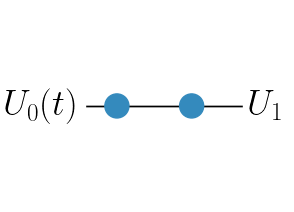

In [13]:
topo = {
    "Nx":               2,
    "Ny":               1,
    "Nz":               1,
    "e_pos":            [[0, 0, 0], [1, 0, 0]],
    "electrode_type":   ['constant', 'constant']
}
sim     = nanonets.simulation(topo)
fig,ax  = nanonets_utils.display_network(sim, provide_electrode_labels=['$U_0(t)$','$U_1$'], font_size=26)

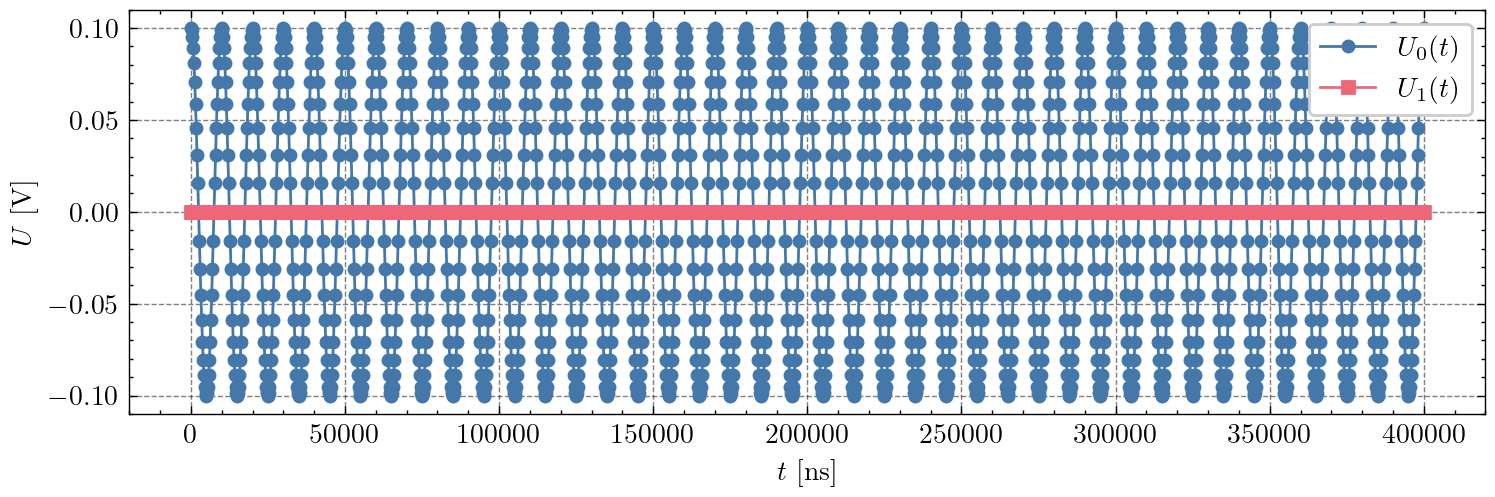

In [16]:
# Time
f_0     = 1e5
dt      = 1 / (40*f_0)
N       = int(np.ceil((N_PERIODS / f_0) / dt))
t       = np.arange(N)*dt

# Volt
U_0     = AMPLITUDE*np.cos(2*np.pi*f_0*t)
U_1     = np.repeat(0,N)
U       = np.zeros(shape=(N,3))
U[:,0]  = U_0
U[:,1]  = U_1

fig,ax = plt.subplots(dpi=200)
fig.set_figwidth(fig.get_figwidth()*2.5)
ax.plot(t*1e9, U_0, '-o', label='$U_0(t)$', ms=4)
ax.plot(t*1e9, U_1, '-s', label='$U_1(t)$', ms=4)
ax.set_ylabel("$U$ [V]")
ax.set_xlabel("$t$ [ns]")
ax.legend()

In [17]:
# Simulation
sim.run_var_voltages(voltages=U, time_steps=t, target_electrode=1, T_val=5.0, save=False, stat_size=20)

In [18]:
# Results
results = pd.DataFrame(sim.return_output_values()[:,1:], columns=['steps','I','u_I'])
pots    = pd.DataFrame(sim.return_potential_landscape())
a, b    = sim.return_network_currents()
currs   = pd.DataFrame(b, columns=a)

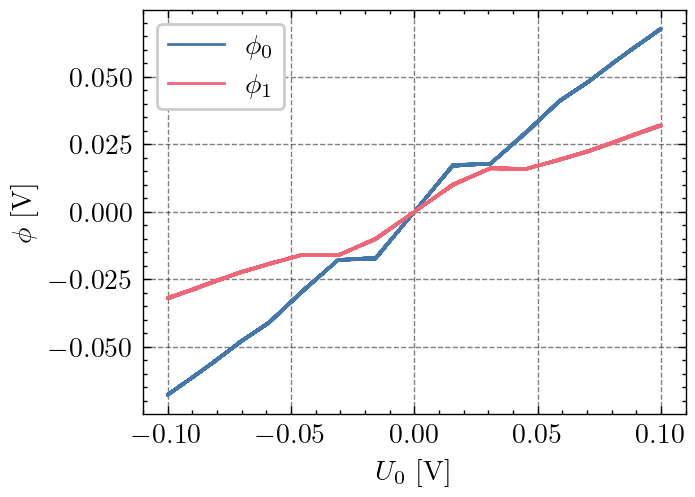

In [19]:
fig,ax = plt.subplots(dpi=200)
ax.plot(pots.iloc[:,0],pots.iloc[:,2], label='$\phi_0$')
ax.plot(pots.iloc[:,0],pots.iloc[:,3], label='$\phi_1$')
ax.set_xlabel('$U_0$ [V]')
ax.set_ylabel('$\phi$ [V]')
ax.legend()

Text(0.5, 0, '$t$ [ns]')

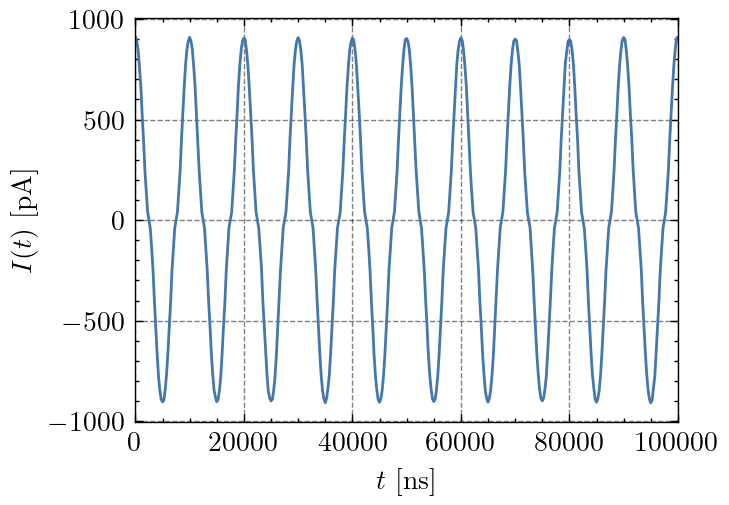

In [20]:
fig,ax = plt.subplots(dpi=200)
ax.plot(t[:-1]*1e9, results['I'])
ax.set_xlim(0,1e5)
ax.set_ylabel('$I(t)$ [pA]')
ax.set_xlabel('$t$ [ns]')

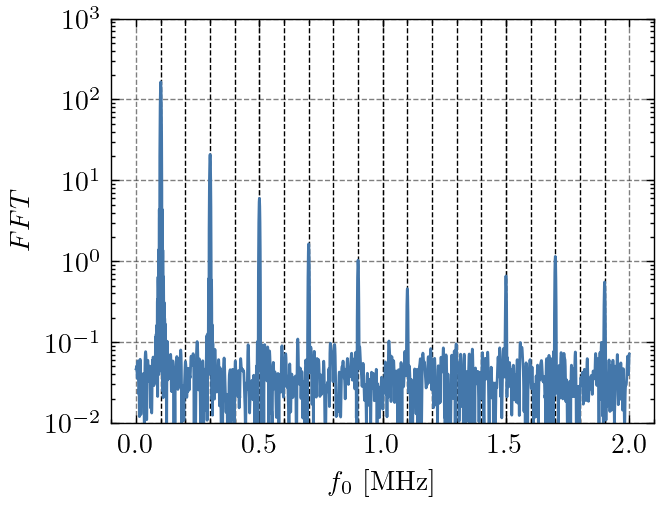

In [21]:
signal  = results['I'].values
xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)

fig,ax = plt.subplots(dpi=200)
ax.plot(xf/1e6, yf)
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-2,1e3)
ax.set_yscale('log')
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-2, 1e3, colors='black', linestyles='--', zorder=0.1, lw=0.5)

Text(0.5, 0, '$|I|$')

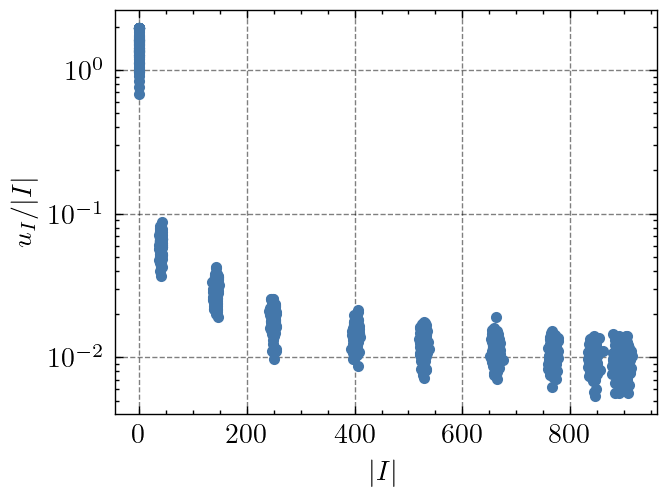

In [22]:
fig,ax  = plt.subplots(dpi=200)
ax.plot(results['I'].abs(),results['u_I']/results['I'].abs(),'.')
ax.set_yscale('log')
ax.set_ylabel('$u_I/|I|$')
ax.set_xlabel('$|I|$')

In [23]:
# FFT
ffts = []
for i in range(4):
    signal  = pots.iloc[:,i]
    xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)
    ffts.append(yf)
ffts = pd.DataFrame(np.array(ffts).T)

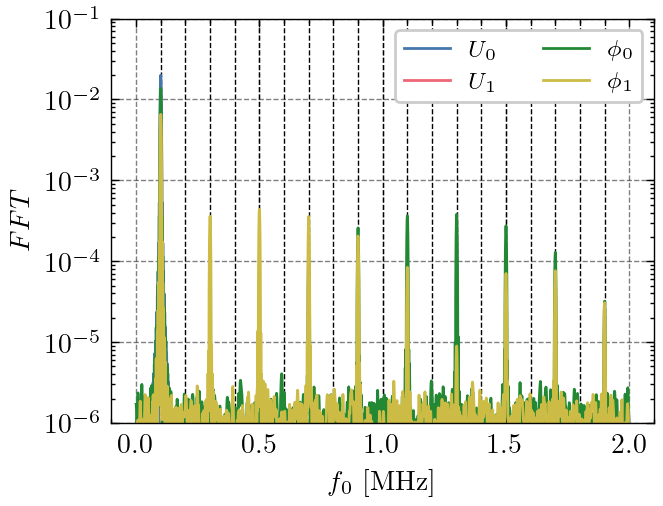

In [24]:
l       = ['$U_0$','$U_1$','$\phi_0$','$\phi_1$']
fig,ax  = plt.subplots(dpi=200)
for i in range(0,4):
    ax.plot(xf/1e6, ffts.iloc[:,i], label=l[i])
ax.set_yscale('log')
ax.legend(ncol=2, fontsize='small', loc='upper right')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-6,1e-1)
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-6, 1e-1, colors='black', linestyles='--', zorder=0.1, lw=0.5)

### Temperature dependency

In [ ]:
def C_s(r):
    factor  = 4 * np.pi * 8.85418781762039e-3 * EPS_S
    cap     = factor * r
    return cap
def C_m(r1,r2):
    # Base factor
    d       = r1 + r2 + 1.0
    factor  = 4 * np.pi * 8.85418781762039e-3 * EPS_R * (r1 * r2) / d
    
    # Terms of the Taylor expansion
    term1       = 1.0
    term2       = (r1 * r2) / (d**2 - 2*r1*r2)
    denominator = d**4 - 4*(d**2)*r1*r2 + 3*(r1**2)*(r2**2)
    term3       = ((r1**2)*(r2**2)) / denominator
    cap         = factor * (term1 + term2 + term3)
                
    return cap

In [52]:
r1,r2   = 10.0, 10.0
C_S1    = C_m(r1,10.0)
C_12    = C_m(r1,r2)
C_2D    = C_m(r2,10.0)
C_1     = C_s(r1)
C_2     = C_s(r2)
D       = (C_S1+C_12+C_1)*(C_12+C_2D+C_2)-C_12**2
alpha   = C_S1*(C_12+C_2D+C_2)/D
beta    = C_S1*C_12/D

In [53]:
T_vals  = np.linspace(1,298,1000)
A_S1    = sim.const_capacitance_values[0]
A_12    = sim.const_capacitance_values[3]
A_2D    = sim.const_capacitance_values[4]
kBT     = sim.kb*T_vals

(0.0, 50.0)

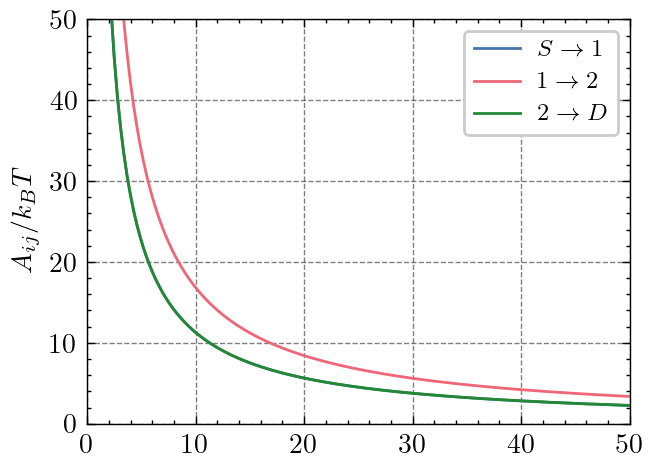

In [77]:
fig, ax = plt.subplots(dpi=200)
ax.plot(T_vals,A_S1/kBT, label='$S \\rightarrow 1$')
ax.plot(T_vals,A_12/kBT, label='$1 \\rightarrow 2$')
ax.plot(T_vals,A_2D/kBT, label='$2 \\rightarrow D$')
ax.set_ylabel("$A_{ij}/k_BT$")
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend(fontsize='small')
ax.set_xlim(0,50)
ax.set_ylim(0,50)

In [78]:
amps    = 0.1
B_S1    = -sim.ele_charge*(alpha-1)*amps
B_12    = sim.ele_charge*(beta-alpha)*amps
B_2D    = -sim.ele_charge*beta*amps

(-50.0, 50.0)

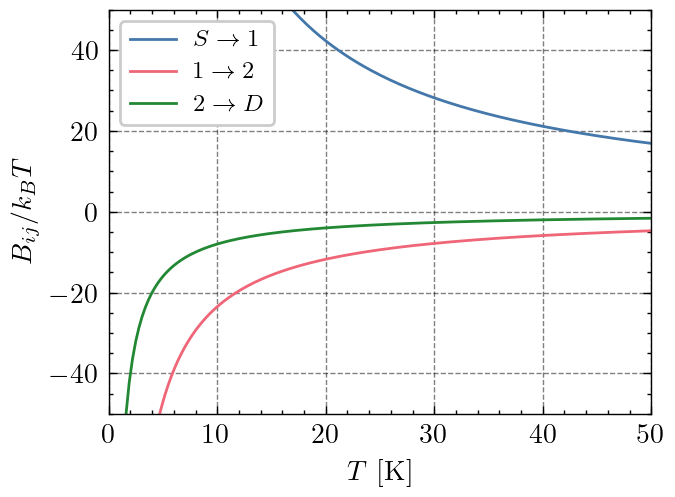

In [83]:
fig, ax = plt.subplots(dpi=200)
ax.plot(T_vals,B_S1/kBT, label='$S \\rightarrow 1$')
ax.plot(T_vals,B_12/kBT, label='$1 \\rightarrow 2$')
ax.plot(T_vals,B_2D/kBT, label='$2 \\rightarrow D$')
ax.set_xlabel("$T$ [K]")
ax.set_ylabel("$B_{ij}/k_BT$")
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend(fontsize='small')
ax.set_xlim(0,50)
ax.set_ylim(-50,50)

In [ ]:
B_S1    = -sim.ele_charge*(alpha-1)*amps
B_12    = sim.ele_charge*(beta-alpha)*amps
B_2D    = -sim.ele_charge*beta*amps

In [167]:
t_vals

array([  0.31622777,   0.3180552 ,   0.3198932 ,   0.32174182,
         0.32360112,   0.32547116,   0.32735201,   0.32924373,
         0.33114639,   0.33306003,   0.33498474,   0.33692057,
         0.33886759,   0.34082585,   0.34279544,   0.34477641,
         0.34676882,   0.34877275,   0.35078826,   0.35281541,
         0.35485428,   0.35690493,   0.35896744,   0.36104186,
         0.36312827,   0.36522674,   0.36733733,   0.36946012,
         0.37159518,   0.37374257,   0.37590238,   0.37807467,
         0.38025951,   0.38245697,   0.38466714,   0.38689007,
         0.38912586,   0.39137456,   0.39363626,   0.39591103,
         0.39819894,   0.40050008,   0.40281451,   0.40514232,
         0.40748358,   0.40983837,   0.41220677,   0.41458885,
         0.4169847 ,   0.4193944 ,   0.42181802,   0.42425564,
         0.42670736,   0.42917324,   0.43165337,   0.43414783,
         0.43665671,   0.43918009,   0.44171805,   0.44427067,
         0.44683805,   0.44942027,   0.4520174 ,   0.45

In [179]:
np.logspace(-2.1,0,1000)

array([0.00794328, 0.00798182, 0.00802055, 0.00805947, 0.00809857,
       0.00813787, 0.00817735, 0.00821703, 0.0082569 , 0.00829696,
       0.00833722, 0.00837767, 0.00841832, 0.00845916, 0.00850021,
       0.00854145, 0.00858289, 0.00862454, 0.00866638, 0.00870843,
       0.00875068, 0.00879314, 0.00883581, 0.00887868, 0.00892176,
       0.00896505, 0.00900855, 0.00905225, 0.00909618, 0.00914031,
       0.00918466, 0.00922922, 0.009274  , 0.009319  , 0.00936422,
       0.00940965, 0.00945531, 0.00950119, 0.00954728, 0.00959361,
       0.00964016, 0.00968693, 0.00973393, 0.00978116, 0.00982862,
       0.00987631, 0.00992423, 0.00997238, 0.01002077, 0.01006939,
       0.01011824, 0.01016734, 0.01021667, 0.01026624, 0.01031605,
       0.01036611, 0.0104164 , 0.01046694, 0.01051773, 0.01056876,
       0.01062004, 0.01067157, 0.01072335, 0.01077538, 0.01082766,
       0.01088019, 0.01093298, 0.01098603, 0.01103934, 0.0110929 ,
       0.01114672, 0.01120081, 0.01125515, 0.01130976, 0.01136

In [180]:
amp_vals    = np.logspace(-2.1,0,1000)#np.linspace(0.01,0.1,1000)
t_vals      = np.logspace(-0.5,2,1000)
B_vals_S1   = np.zeros((1000,1000))
B_vals_12   = np.zeros((1000,1000))
B_vals_2D   = np.zeros((1000,1000))

for i,amp_val in enumerate(amp_vals):
    for j,T_val in enumerate(t_vals):
        B_vals_S1[i,j] = np.abs(sim.ele_charge*(alpha-1)*amp_val/(sim.kb*T_val))
        B_vals_12[i,j] = np.abs(sim.ele_charge*(beta-alpha)*amp_val/(sim.kb*T_val))
        B_vals_2D[i,j] = np.abs(sim.ele_charge*beta*amp_val/(sim.kb*T_val))

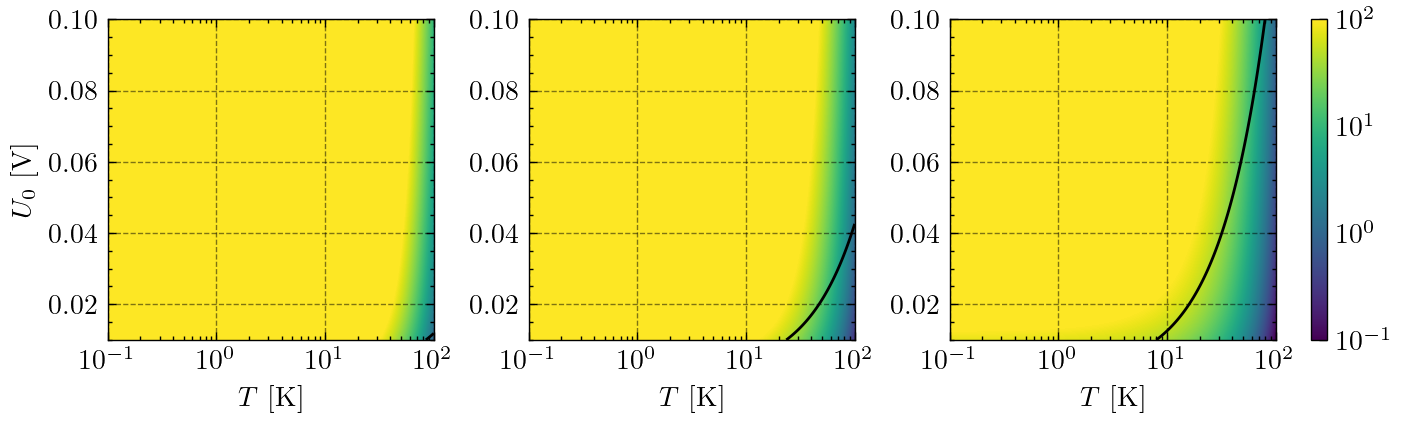

In [154]:
fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*0.8)
ax  = fig.add_subplot(1,3,1)
im  = plt.imshow(B_vals_S1, norm=LogNorm(vmin=1e-1, vmax=1e2),
                 extent=[t_vals.min(), t_vals.max(), amp_vals.min(), amp_vals.max()],
                 aspect='auto',origin='lower')
ax.contour(t_vals,amp_vals,B_vals_S1,levels=[1.0],colors='k',linewidths=1.0)
ax.set_xlabel("$T$ [K]")
ax.set_ylabel("$U_0$ [V]")
ax.set_xscale("log")

ax  = fig.add_subplot(1,3,2)
im  = plt.imshow(B_vals_12, norm=LogNorm(vmin=1e-1, vmax=1e2),
                 extent=[t_vals.min(), t_vals.max(), amp_vals.min(), amp_vals.max()],
                 aspect='auto',origin='lower')
ax.contour(t_vals,amp_vals,B_vals_12,levels=[1.0],colors='k',linewidths=1.0)
ax.set_xlabel("$T$ [K]")
ax.set_xscale("log")

ax  = fig.add_subplot(1,3,3)
im  = plt.imshow(B_vals_2D, norm=LogNorm(vmin=1e-1, vmax=1e2),
                 extent=[t_vals.min(), t_vals.max(), amp_vals.min(), amp_vals.max()],
                 aspect='auto',origin='lower')
ax.contour(t_vals,amp_vals,B_vals_2D,levels=[1.0],colors='k',linewidths=1.0)
ax.set_xlabel("$T$ [K]")
ax.set_xscale("log")

cbar = fig.colorbar(im)
cbar.set_label("")

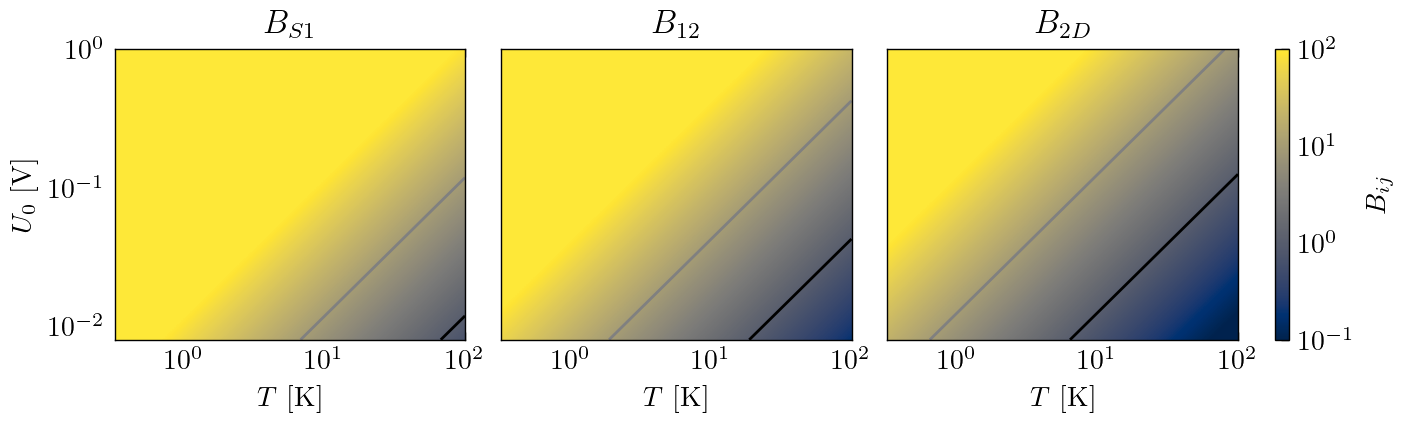

In [199]:
# 1) Build a meshgrid (centers or edges) for pcolormesh:
TT, AA = np.meshgrid(t_vals, amp_vals)  # both shape = (1000, 1000)

fig = plt.figure(dpi=200, layout='constrained')
fig.set_figwidth(fig.get_figwidth()*2)
fig.set_figheight(fig.get_figheight()*0.8)

# Plot B_vals_S1:
ax1 = fig.add_subplot(1, 3, 1)
pcm1 = ax1.pcolormesh(
    TT, AA, B_vals_S1,
    norm=LogNorm(vmin=1e-1, vmax=1e2),
    shading='auto', cmap='cividis'
)
# Contour where B = 1:
cs1 = ax1.contour(TT, AA, B_vals_S1, levels=[1.0], colors='black', linewidths=1.0)
cs1 = ax1.contour(TT, AA, B_vals_S1, levels=[10.0], colors='grey', linewidths=1.0)
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel("$T$ [K]")
ax1.set_ylabel("$U_0$ [V]")
ax1.set_title("$B_{S1}$")

# Plot B_vals_12:
ax2 = fig.add_subplot(1, 3, 2)
pcm2 = ax2.pcolormesh(
    TT, AA, B_vals_12,
    norm=LogNorm(vmin=1e-1, vmax=1e2),
    shading='auto', cmap='cividis'
)
cs2 = ax2.contour(TT, AA, B_vals_12, levels=[1.0], colors='black', linewidths=1.0)
cs2 = ax2.contour(TT, AA, B_vals_12, levels=[10.0], colors='grey', linewidths=1.0)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlabel("$T$ [K]")
ax2.set_title("$B_{12}$")
ax2.set_yticklabels("")

# Plot B_vals_2D:
ax3 = fig.add_subplot(1, 3, 3)
pcm3 = ax3.pcolormesh(
    TT, AA, B_vals_2D,
    norm=LogNorm(vmin=1e-1, vmax=1e2),
    shading='auto', cmap='cividis'
)
cs3 = ax3.contour(TT, AA, B_vals_2D, levels=[1.0], colors='black', linewidths=1.0)
cs3 = ax3.contour(TT, AA, B_vals_2D, levels=[10.0], colors='grey', linewidths=1.0)
ax3.set_xscale("log")
ax3.set_yscale("log")
ax3.set_xlabel("$T$ [K]")
ax3.set_title("$B_{2D}$")
ax3.set_yticklabels("")

# Colorbar (shared):
cbar = fig.colorbar(pcm3, orientation='vertical')
cbar.set_label("$B_{ij}$")

In [119]:
B_vals

array([[-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       [-2.35099486e-01, -1.81222521e-01, -1.47435271e-01, ...,
        -7.90501725e-04, -7.89712300e-04, -7.88924450e-04],
       [-4.70198972e-01, -3.62445041e-01, -2.94870542e-01, ...,
        -1.58100345e-03, -1.57942460e-03, -1.57784890e-03],
       ...,
       [-2.34394188e+02, -1.80678853e+02, -1.46992965e+02, ...,
        -7.88130220e-01, -7.87343163e-01, -7.86557677e-01],
       [-2.34629287e+02, -1.80860076e+02, -1.47140400e+02, ...,
        -7.88920722e-01, -7.88132876e-01, -7.87346601e-01],
       [-2.34864387e+02, -1.81041298e+02, -1.47287836e+02, ...,
        -7.89711224e-01, -7.88922588e-01, -7.88135526e-01]])

<Axes: >

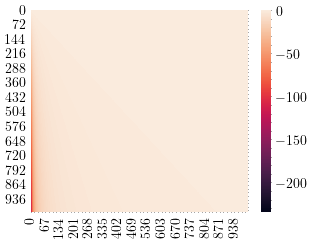

In [96]:
sns.heatmap(np.array(B_vals).reshape(1000,1000))

### 2 NP Device of unequal NP-Size

In [319]:
np2     = {'np_index': [1],
        'mean_radius': 1e7,
        'std_radius': 0.0}
sim2    = nanonets.simulation(topo, np_info2=np2)

In [320]:
# Simulation
sim2.run_var_voltages(voltages=U, time_steps=t, target_electrode=1, T_val=5.0, save=False, stat_size=20)

In [327]:
# Results
results2 = pd.DataFrame(sim2.return_output_values()[:,1:], columns=['steps','I','u_I'])
pots2    = pd.DataFrame(sim2.return_potential_landscape())
a, b     = sim2.return_network_currents()
currs2   = pd.DataFrame(b, columns=a)

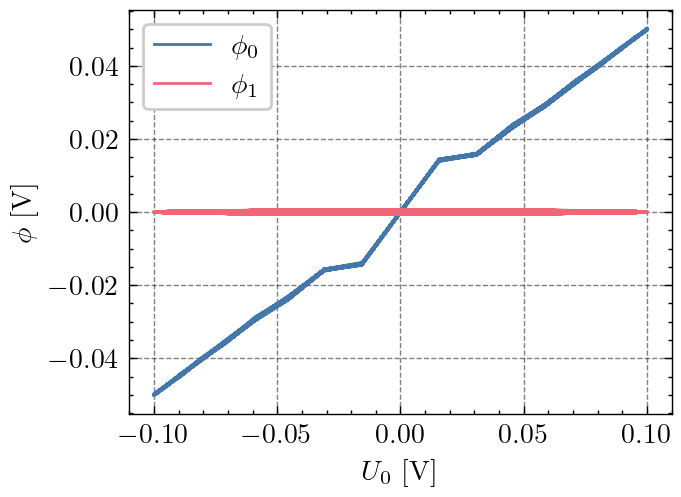

In [328]:
fig,ax = plt.subplots(dpi=200)
ax.plot(pots2.iloc[:,0],pots2.iloc[:,2], label='$\phi_0$')
ax.plot(pots2.iloc[:,0],pots2.iloc[:,3], label='$\phi_1$')
ax.set_xlabel('$U_0$ [V]')
ax.set_ylabel('$\phi$ [V]')
ax.legend()

Text(0.5, 0, '$t$ [ns]')

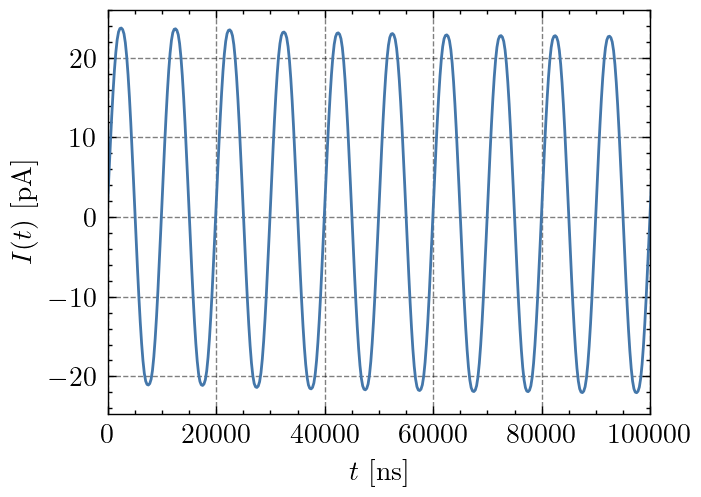

In [329]:
fig,ax = plt.subplots(dpi=200)
ax.plot(t[:-1]*1e9, results2['I'])
ax.set_xlim(0,1e5)
ax.set_ylabel('$I(t)$ [pA]')
ax.set_xlabel('$t$ [ns]')

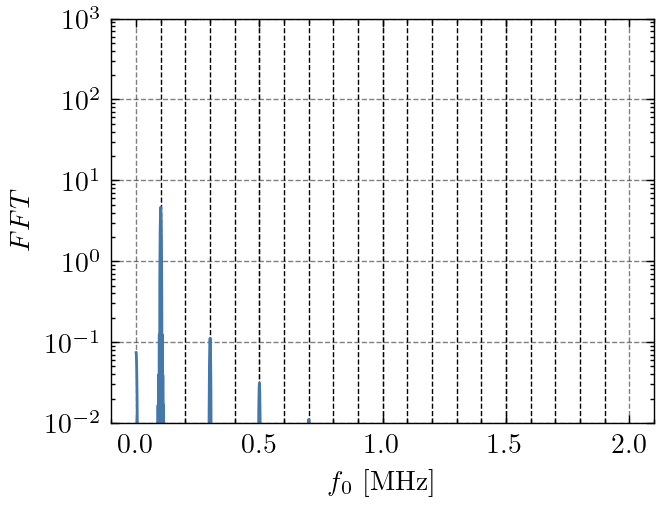

In [333]:
signal  = results2['I'].values
xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)

fig,ax = plt.subplots(dpi=200)
ax.plot(xf/1e6, yf)
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-2,1e3)
ax.set_yscale('log')
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-2, 1e3, colors='black', linestyles='--', zorder=0.1, lw=0.5)

Text(0.5, 0, '$|I|$')

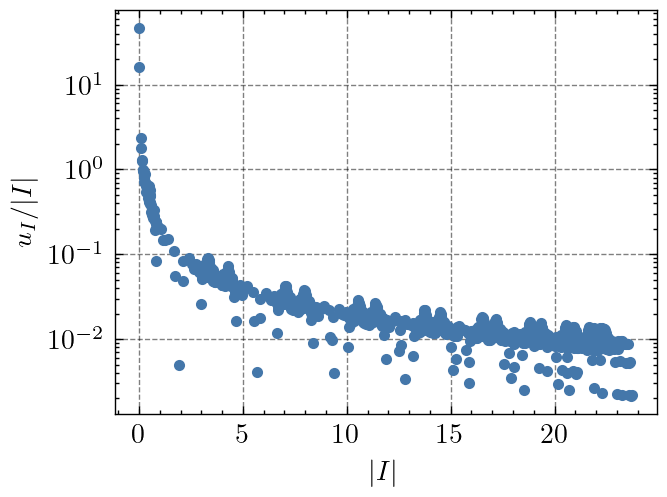

In [334]:
fig,ax  = plt.subplots(dpi=200)
ax.plot(results2['I'].abs(),results2['u_I']/results2['I'].abs(),'.')
ax.set_yscale('log')
ax.set_ylabel('$u_I/|I|$')
ax.set_xlabel('$|I|$')

In [335]:
# FFT
ffts = []
for i in range(4):
    signal  = pots2.iloc[:,i]
    xf, yf  = nanonets_utils.fft(signal=signal, dt=dt, n_padded=len(signal)*5, use_hann=True)
    ffts.append(yf)
ffts = pd.DataFrame(np.array(ffts).T)

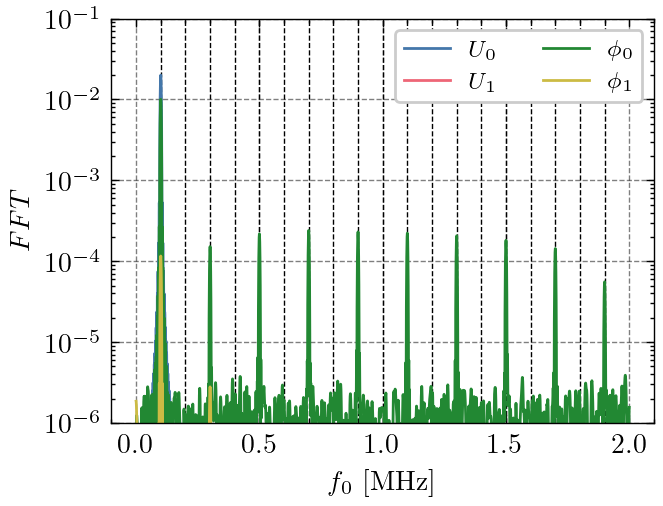

In [336]:
l       = ['$U_0$','$U_1$','$\phi_0$','$\phi_1$']
fig,ax  = plt.subplots(dpi=200)
for i in range(0,4):
    ax.plot(xf/1e6, ffts.iloc[:,i], label=l[i])
ax.set_yscale('log')
ax.legend(ncol=2, fontsize='small', loc='upper right')
ax.set_xlabel("$f_0$ [MHz]")
ax.set_ylabel("$FFT$")
ax.set_ylim(1e-6,1e-1)
ax.vlines([i*f_0/1e6 for i in range(1,20)], 1e-6, 1e-1, colors='black', linestyles='--', zorder=0.1, lw=0.5)